In [1]:
# system modules
import os,sys,copy
from importlib import reload
## numerical modules
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.convolution import convolve_models
from astropy.modeling import models,fitting
from astropy.utils.exceptions import AstropyUserWarning
## plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm
import cmasher as cmr
## custom modules
## add AGE-PRO data manipulation script to path [replace this with your own path]
sys.path.append(os.path.join('/home/ltrapman','Science','git-repos','data-manipulation-scripts'))
from class_agepro_obs import agepro_obs,Nuker2D

## a place to save all figures
plotdir  = os.path.join('.','Plots')
if not os.path.isdir(plotdir): os.makedirs(plotdir)

## 1. Load in the data

The the code cell below loads in the data and sets the orientation of the disk. After that, it creates a Keplerian mask using the provided disk and stellar parameters. This mask is then applied when the 3D spectral cube is collapsed along its spectral axis to create an integrated intensity (moment zero) map.

Note that you can also load in the moment zero map directly. In that case, do not forget to comment out the ```obs.make_keplerian_mask()``` and ```obs.collapse_cube()``` steps. 

In [2]:
source = 'Lupus_3'
line = 'CO'
## path to the fitsfile
path_to_file = os.path.join(os.environ['agepro'],'Data_products','Lupus',
                            'Lupus_3_J16124373-3815031','Lupus_3_J16124373-3815031_CO_B6')
## name of the fitsfile
fitsfile = 'Lupus_3_J16124373-3815031_CO_0.1kms_Band6.pbcor.fits'

#### load in the data       
obs = agepro_obs(os.path.join(path_to_file,fitsfile),FOV=10,source=source,line=line)  
max_velocity = 12e3   ## [m/s]
min_velocity = -4e3  ## [m/s]
obs.set_velocity_range(v_min=min_velocity,v_max=max_velocity)

#### project radial coordinates
PA  = 198 ## [deg]
inc = 51  ## [deg]
obs.project_rgrid(PA=PA,inc=inc)

#### make a Keplerian mask
dist  = 160    ## [parcsec]
mstar = 0.8    ## [Msun]
vlsr  = 4.6e3  ## [m/s]
Rmax  = 1.2    ## [arcsec]
zr=0
if line=='CO':   zr=0.23
if line=='13CO': zr=0.15
if line=='C18O': zr=0.1
if line=='N2Hp': zr=0.05

#### make a Keplerian mask
obs.make_keplerian_mask(PA=PA,inc=inc,dist=dist,mstar=mstar,nbeams=2,vlsr=vlsr,r_max=1.2*Rmax,z0=zr)

#### collapse cube to make a moment 0 map
obs.collapse_cube()

## save the moment 0 map
obs.save_moment_map(method='zeroth')

Number of noise channels found: 240


100%|███████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 30.49it/s]


## 2. Inspect the data

When applying a mask to data it is worthwhile to examine not just the moment zero map but also the masked out regions of the data cube. The code in the cell shows two images. On the left we have the moment zero map of the intensity inside the Keplerian mask. On the right we hav a moment zero map of all the emission outside this mask. 

For the example data used here most of the source emission is within the Keplerian mask, but there could be a tiny amount of source emission outside the mask.

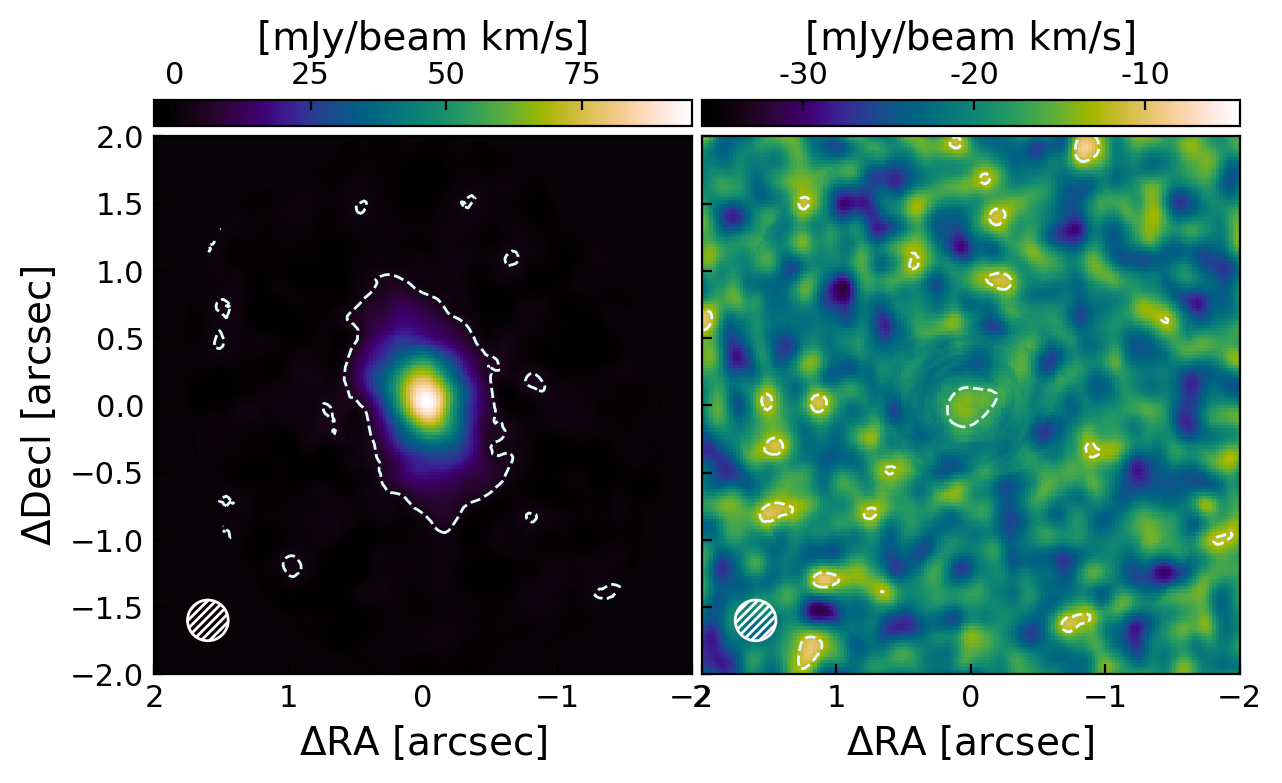

In [5]:
fig  = plt.figure(figsize = (7.4,3.4))
plt.subplots_adjust(top=0.98,left=0.11,right=0.88,bottom=0.135)
grid = AxesGrid(fig, 111, nrows_ncols=(1,2),axes_pad=0.05,share_all=True,label_mode="L",cbar_location="top",
                      cbar_mode="each",cbar_size ='5.0%')
ax = grid[0]
axres = grid[1]
cmap = cmr.rainforest
lims = (-2,2)

##------ plot the moment map
## showing the image
cb = ax.imshow(obs.image,extent=obs.extent,vmin=None,origin='lower',cmap=cmap)
## add the 3 sigma contours
ax.contour(obs.image/obs.noisemap,levels=[3],extent=obs.extent,colors=['lightcyan'],linewidths=[1],linestyles=['--'])

## colorbar
cbar = ax.cax.colorbar(cb,ticklocation='top')
ax.cax.toggle_label(True)

cbar.ax.set_xticklabels(['{:.0f}'.format(tick) for tick in cbar.ax.get_xticks()],ha='center',rotation=0,fontsize=11)
cbar.ax.tick_params(axis='x',labelsize=11)
cbar.ax.set_xlabel('[mJy/beam km/s]',fontsize=14)

## beam
ax.set_xlim(lims[1],lims[0])
ax.set_ylim(*lims)
obs.plot_beam(ax,color='w')

## axes formation
ax.tick_params(axis='x',labelsize=11)
ax.tick_params(axis='y',labelsize=11)
ax.set_xlabel(r'$\Delta$RA [arcsec]',fontsize=14)
ax.set_ylabel(r'$\Delta$Decl [arcsec]',fontsize=14)

## --- plot the inversely masked moment map
import copy
obs.actual_mask = copy.deepcopy(obs.mask)
obs.mask = np.abs(obs.actual_mask-1)
obs.collapse_cube()
cb = axres.imshow(obs.image,extent=obs.extent,vmin=None,vmax=None,origin='lower',cmap=cmap)
## add the 3 sigma contours
if hasattr(obs,'noisemap'):
    axres.contour(obs.image/obs.noisemap,levels=[3],extent=obs.extent,colors=['lightcyan'],linewidths=[1],linestyles=['--'])

## colorbar
cbar = axres.cax.colorbar(cb,ticklocation='top')
axres.cax.toggle_label(True)
cbar.ax.set_xticklabels(['{:.0f}'.format(tick) for tick in cbar.ax.get_xticks()],ha='center',rotation=0,fontsize=11)
cbar.ax.tick_params(axis='x',labelsize=11)
cbar.ax.set_xlabel('[mJy/beam km/s]',fontsize=14)

## beam
axres.set_xlim(lims[1],lims[0])
axres.set_ylim(*lims)
obs.plot_beam(axres,color='w')

## axes formation
axres.tick_params(axis='x',labelsize=11)
axres.tick_params(axis='y',labelsize=11)
axres.set_xlabel(r'$\Delta$RA [arcsec]',fontsize=14)
axres.set_ylabel(r'$\Delta$Decl [arcsec]',fontsize=14)

plt.show()
## reset to the original state
obs.mask = obs.actual_mask
obs.collapse_cube()

## 3. Fit the observations

Below we fit the moment zero map using a Nuker intensity profile, convolved with the CLEAN beam of the observations. The ```guess``` parameter allows you to provide an initial guess for the fit. You exclude parameters from the fit by adding them to the ```fixed```. For example, ```fixed={x_0:True,y_0:True}``` fixes the center during the fit. 

To quickly go over the other parameters:
* ```diagnostic=True``` produces the figures seen below.
* ```include_noise=True``` sets the weights to ```1/obs.noisemap``` during the fit.
* ```return_fit=True,return_figure=True``` make it so that the fit results and the diagnostic figure are returned by the function.
* ```kwargs_fit,kwargs_plot``` are keyword arguments that get passed along to the fitter and the diagnostic plot, respectively.

model: Nuker2D
fitter: LMLSQFitter
 * fitting observations with beam-convolved model


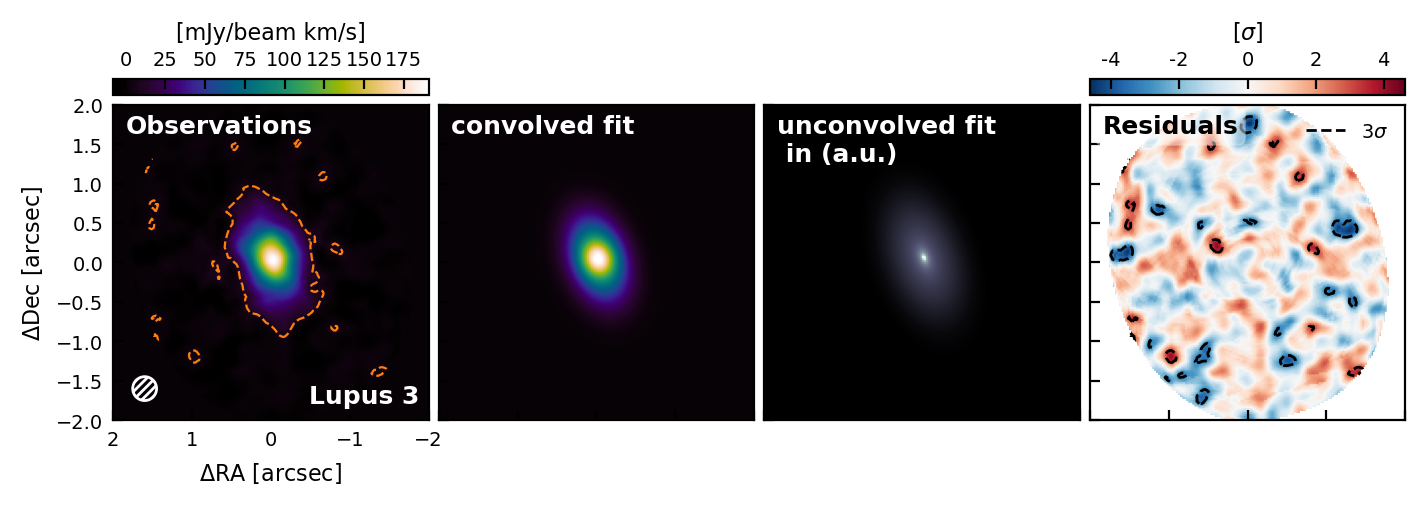

* fit summary 
--------------------
amplitude   :  26.90
x_0         :  -0.03
y_0         :   0.06
r_t         :   1.37
gamma       :   0.90
alpha       :   3.72
beta        :  40.01
PA          : 198.63
inc         :  55.11


In [6]:
output = obs.fit_observations('nuker',
                              guess={'PA':obs.PA,'inc':obs.inc,'amplitude':48.,'r_t':1.06,'beta':15,'alpha':3.6,'gamma':0.84},
                              fixed={'PA':False,'inc':False,'amplitude':False,'x_0':False,'y_0':False},
                              diagnostic=True,include_noise=True,return_fit=True,
                              return_figure=True,
                              kwargs_fit={'maxiter':2000},
                              kwargs_plot={'lims':(-2,2),'cmap':cmr.rainforest})

fitted_model,fit_info,figure,_ = output

## save the figure
figure.savefig(os.path.join(plotdir,'Lupus_3_Nuker_fit.pdf'))

## summarize the best fit parameters
fit_output = dict(zip(fitted_model.param_names,fitted_model.parameters))
print('* fit summary ')
print('--'*10)
for key,val in fit_output.items():
    print('{:<12}: {:6.2f}'.format(key,val))


## 4. Measure the size of the model

Once a model has been fit we can measure its size, i.e. the radius that encloses a certain fraction of its total flux. The simplest option would be to calculate this radius from the the best fitting model. However, the uncertainties from fitting the the model should be propagated into uncertainties on the model size. This is done using ```calculate_uncertainties=True```, which is the default for ```obs.calculate_model_size()```. The code uses a Monte Carlo method to draw sets of model parameters from the fitting results (best fit & the covariance matrix) and measures the model size for each combination. In the example below the model size and its uncertainties are calculated as the median and 16th/84th quantiles of the model size distribution. This should be considered a good default setup, but see the function API for more options.

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.37it/s]


Number of negative curves: 0/2000


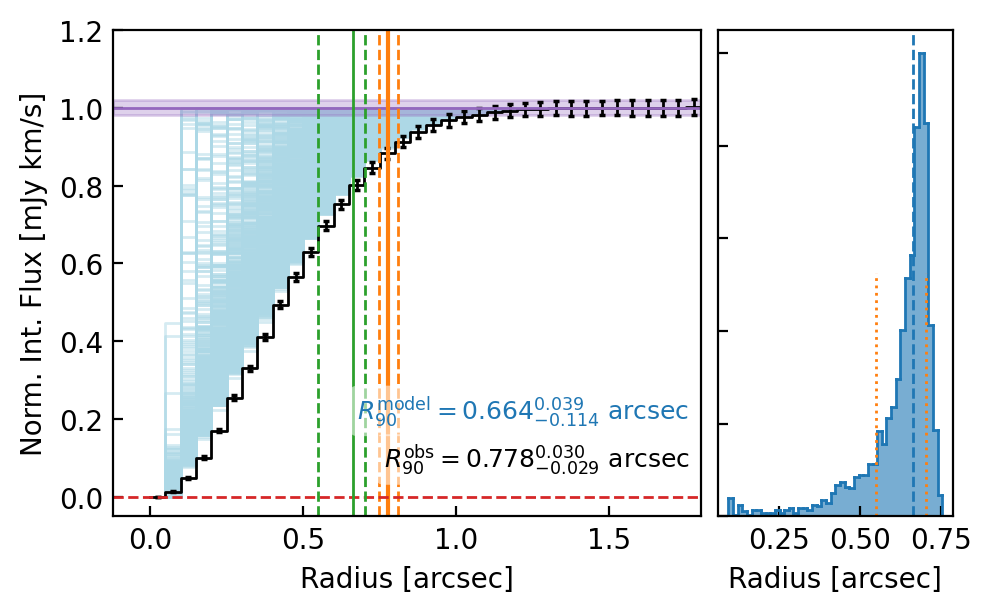

In [10]:
outp = obs.calculate_model_size(0.9,Rmax=Rmax,dr = 2*obs.dpix,diagnostic=True,
                                iterations=2000,return_distribution=True,
                                return_median=True,return_figure=True)

R90_bestfit,(R90_min,R90_median,R90_max),size_posterior,figure,ax = outp
## save the figure
figure.savefig(os.path.join(plotdir,'Lupus_3_Nuker_curve.pdf'))

## save results
np.save(os.path.join('.','Lupus_3_Nuker_fits_posterior.npy'),size_posterior)


In the left panel the black line shows the integrated flux curve-of-growth and the orange vertical lines show the radius that encloses 90% of the total flux, R90, (solid) and its uncertainties (dashed). The right panel shows the distribution of the R90 from the Monte Carlo method used to derive the uncertainties on the model R90. The dashed and dotted lines shows the median and 16/84th quantile of this distribution. These quantiles are also included in the right figure in the form of green solid and dashed lines. Finally, the blue lines in the left panel show a subset of the curve-of-growths used in the Monte Carlo method.

## extra: masking parts of the emission

While fitting it is possible to mask out parts of the emission. This can be useful to remove cloud emission or remove emission from a (binary) companion. The example below shows how to mask out emission outside a given radius (```mask_Rmax```) and inside a range of angles (```mask_theta```). Note that the angles are given in terms of position angle, which each set of two numbers describing the region that should be masked out. In the example here we have masked everything between 0<PA<80, 175<PA<265, and 330<PA<360 (As a reminder, PA=0=360).

model: Sersic2D
fitter: LMLSQFitter
 * fitting observations with beam-convolved model


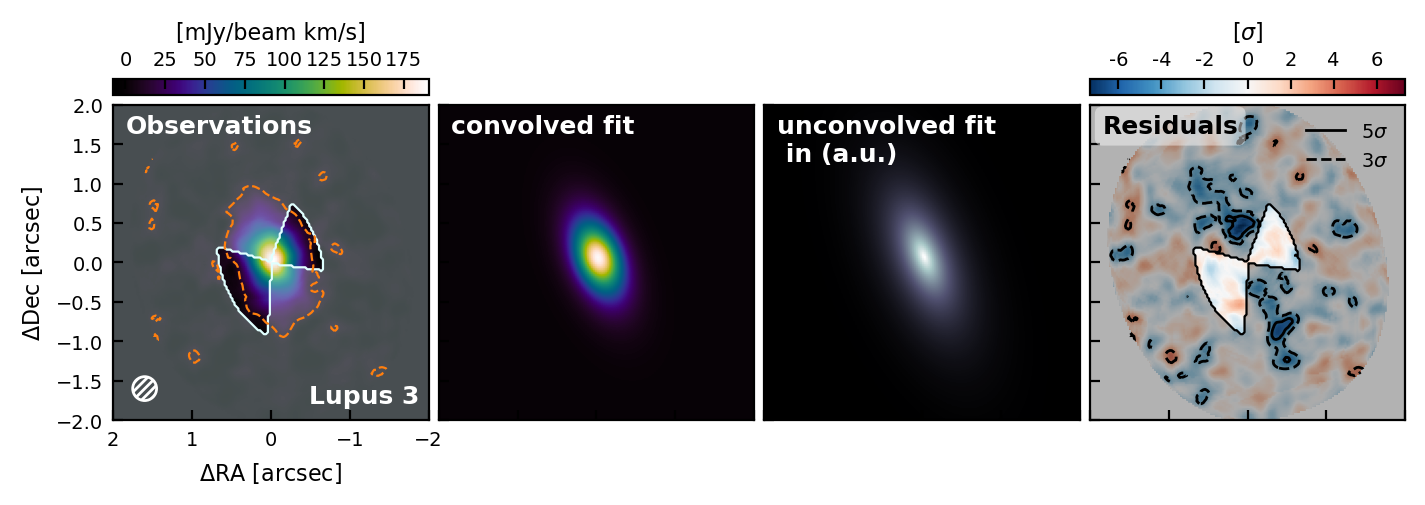

* fit summary 
--------------------
amplitude   :  85.53
r_eff       :   0.44
n           :   0.94
x_0         :  -0.03
y_0         :   0.07
ellip       :   0.54
theta       :   1.20


In [14]:
outputSERSIC = obs.fit_observations('Sersic2D',
                              guess={'theta':np.deg2rad(270-obs.PA-3),'amplitude':120,'r_eff':0.35},
                              fixed={'theta':True},
                              mask_theta = (0,80,175,265,330,360),
                              mask_Rmax = 1.0,
                              diagnostic=True,include_noise=True,return_fit=True,
                              return_figure=False,
                              kwargs_fit={'maxiter':2000},
                              kwargs_plot={'lims':(-2,2),'cmap':cmr.rainforest})

fitted_model,fit_info = outputSERSIC

## summarize the best fit parameters
fit_outputSERSIC = dict(zip(fitted_model.param_names,fitted_model.parameters))
print('* fit summary ')
print('--'*10)
for key,val in fit_outputSERSIC.items():
    print('{:<12}: {:6.2f}'.format(key,val))
